In [1]:
import os
gpu_id = 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

import torch
import torch.nn.functional as F
import numpy as np
import cv2
import time
import cv2
import sys
import json
import time
import mmcv
import glob
import torch
import shutil
import random
import pickle
import hashlib
import numpy as np
import torch.nn as nn
from torch import optim
import mediapy as media
import matplotlib.pyplot as plt
from argparse import ArgumentParser
import torch.nn.functional as torch_F
from transforms3d import affines, quaternions
from torchvision.ops import roi_align
from pytorch3d import io as py3d_io
from pytorch3d import ops as py3d_ops
from pytorch3d import loss as py3d_loss
from pytorch3d import utils as py3d_util
from pytorch3d import structures as py3d_struct
from pytorch3d import renderer as py3d_renderer
from pytorch3d import transforms as py3d_transform
from pytorch3d.vis import plotly_vis as py3d_vis
from pytorch3d.transforms import (matrix_to_euler_angles,
                                  euler_angles_to_matrix, 
                                  matrix_to_rotation_6d, 
                                  rotation_6d_to_matrix,
                                  quaternion_to_matrix, matrix_to_quaternion, quaternion_multiply)
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

PROJ_ROOT = os.path.dirname(os.getcwd())
sys.path.append(PROJ_ROOT)

L1Loss = torch.nn.L1Loss(reduction='mean')
MSELoss = torch.nn.MSELoss(reduction='mean')
SSIM_METRIC = SSIM(data_range=1, size_average=True, channel=3) # channel=1 for grayscale images
MS_SSIM_METRIC = MS_SSIM(data_range=1, size_average=True, channel=3)


from inference import *
from misc_utils import gs_utils
from misc_utils.metric_utils import *
from config import inference_cfg as CFG
from model.network import model_arch as ModelNet
from dataset.demo_dataset import OnePoseCap_Dataset


ckpt_file = os.path.join(PROJ_ROOT, 'checkpoints/model_weights.pth')
device = torch.device('cuda:0')
model_net = ModelNet().to(device)
model_net.load_state_dict(torch.load(ckpt_file, map_location=device))
model_net.eval()
print('Model weights are loaded!')

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/joao/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/joao/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/joao/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Pretrained weights are loaded from  model_weights.pth
Model weights are loaded!


### Playground

In [2]:
test_name = "lion_close"
upscale = 2

Colors shape: (462, 62, 3)
Points shape: (462, 62, 3)


/tmp/ipykernel_74635/1888295357.py:17: RuntimeWarning: invalid value encountered in divide
  xyztVis[..., 2] /= xyzt[..., 2]


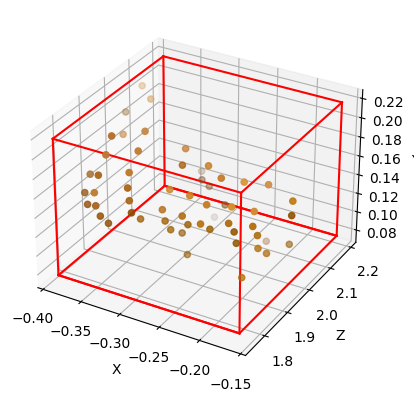

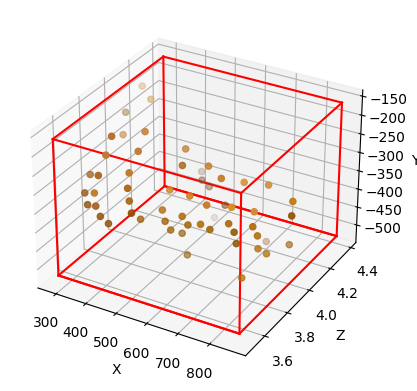

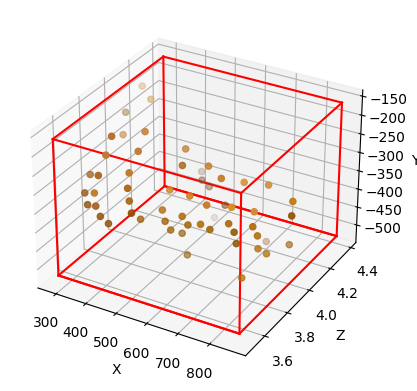

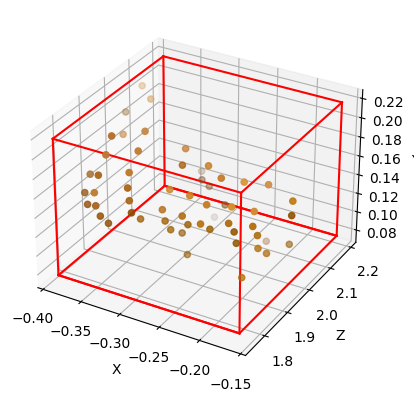

In [3]:
def get_mask(mask_path):
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = mask > 0
    return mask


def from_coordinates_to_pixels(xyztVis, xyzt, W, H):
    intr = np.array([[W, 0.0, W//2],
                [0.0, W, H//2],
                [0.0, 0.0, 1.0]])
    T = xyzt.shape[0]
    
    xyztVis = xyztVis.copy()
    
    # Step 1: Undo the Z-coordinate scaling
    xyztVis[..., 2] /= xyzt[..., 2]
    # Where NaNs are present, replace with 0
    xyztVis[np.isnan(xyztVis)] = 0

    # Step 2: Reshape for matrix multiplication
    xyztVis_reverted = xyztVis.reshape(-1, 3, 1)  # (TN) x 3 x 1

    # Step 3: Apply the original intrinsic matrix (intr) back to recover the original coordinates
    xyzt_reverted = intr[None, ...] @ xyztVis_reverted  # (TN) x 3 x 1

    # Step 4: Reshape back to the original dimensions T x N x 3
    xyzt_reverted = xyzt_reverted.reshape(T, -1, 3)
    
    # Step 5: Undo the Z-coordinate scaling
    xyzt_reverted[..., 2] = xyzt[..., 2]
    
    return xyzt_reverted

def get_segmented_indexes(mask, points):
    points_frame0 = points[0]
    obj_indexes = []
    for i in range(len(points_frame0)):
        x, y = points_frame0[i, 0], points_frame0[i, 1]
        if mask[int(y), int(x)]:
            obj_indexes.append(i)
    
    return obj_indexes

def filter_segmented_pixels(mask, points, colors = None):
    """
    Filter points that are not in the mask, by looking at the
    mask values at the points' coordinates of the first frame.
    
    points: np.array of shape (T, N, 3)
    
    result: np.array of shape (T, M, 3)
    """
    points_frame0 = points[0]
    obj_indexes = []
    for i in range(len(points_frame0)):
        x, y = points_frame0[i, 0], points_frame0[i, 1]
        if mask[int(y), int(x)]:
            obj_indexes.append(i)
    if colors is not None:
        return points[:, obj_indexes], colors[:, obj_indexes]
    return points[:, obj_indexes]

def get_points_bounding_box_and_center(points):
    """
    Get the bounding box of the points.
    
    points: np.array of shape (N, 3)
    
    result: np.array of shape (T, 6)
    """
    min_x, min_y, min_z = np.min(points, axis=0)
    max_x, max_y, max_z = np.max(points, axis=0)
    center = np.mean(points, axis=0)
    return np.array([[min_x, min_y, min_z, max_x, max_y, max_z]]), np.array([center])

def plot_points(points, colors):
    """
    Plot the points in 3D along with their bounding box.
    
    points: np.array of shape (N, 3)
    colors: np.array of shape (N, 3)
    """
    bounding_box, center = get_points_bounding_box_and_center(points)
    # Plot the points and the bounding box
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 2], -points[:, 1], c=colors/255)
    # Add axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')
    # Plot the bounding box
    min_x, min_y, min_z, max_x, max_y, max_z = bounding_box[0]
    ax.plot([min_x, min_x], [min_z, min_z], [-min_y, -max_y], color='r')
    ax.plot([min_x, min_x], [min_z, max_z], [-min_y, -min_y], color='r')
    ax.plot([min_x, min_x], [min_z, max_z], [-max_y, -max_y], color='r')
    ax.plot([max_x, max_x], [min_z, min_z], [-min_y, -max_y], color='r')
    ax.plot([max_x, max_x], [min_z, max_z], [-min_y, -min_y], color='r')
    ax.plot([max_x, max_x], [min_z, max_z], [-max_y, -max_y], color='r')
    ax.plot([min_x, max_x], [min_z, min_z], [-min_y, -min_y], color='r')
    ax.plot([min_x, max_x], [min_z, min_z], [-max_y, -max_y], color='r')
    ax.plot([min_x, max_x], [min_z, min_z], [-max_y, -max_y], color='r')
    ax.plot([min_x, max_x], [max_z, max_z], [-min_y, -min_y], color='r')
    ax.plot([min_x, max_x], [max_z, max_z], [-max_y, -max_y], color='r')
    ax.plot([min_x, max_x], [max_z, max_z], [-max_y, -max_y], color='r')
    ax.plot([min_x, min_x], [max_z, max_z], [-min_y, -max_y], color='r')
    ax.plot([max_x, max_x], [max_z, max_z], [-min_y, -max_y], color='r')
    # Plot the center
    plt.show()
    
def get_black_video(video_path, frame_length = None):
    video = media.read_video(video_path)
    black_video = []
    frame = video[0]
    if frame_length is None:
        frame_length = len(video)
    for i in range(frame_length):
        black_frame = np.zeros_like(frame)
        black_video.append(black_frame)
    return black_video
    
def plot_video(video_frames, points, colors, fps=1):
    """
    Plot the video frames with the points overlaid.
    
    video_frames: list of np.arrays of shape (H, W, 3)
    points: np.array of shape (T, N, 3)
    colors: np.array of shape (T, N, 3)
    """
    video_frames = []
    for t in range(len(video)):
        video_frame = video[t]
        video_frame = cv2.cvtColor(video_frame, cv2.COLOR_RGB2GRAY)
        video_frame = cv2.cvtColor(video_frame, cv2.COLOR_GRAY2RGB)
        # Overlay the points on the video frame
        points_t = int(t / fps)
        for i in range(len(points[points_t])):
            x, y = points[points_t][i, 0], points[points_t][i, 1]
            cv2.circle(video_frame, (int(x), int(y)), 2, colors[points_t][i], -1)
        video_frames.append(video_frame)
    media.show_video(video_frames, fps=15)
    
def plot_video_comparison(video_frames, prediction, target, fps=1):
    video_frames = []
    for t in range(len(video)):
        video_frame = video[t]
        video_frame = cv2.cvtColor(video_frame, cv2.COLOR_RGB2GRAY)
        video_frame = cv2.cvtColor(video_frame, cv2.COLOR_GRAY2RGB)
        # Overlay the points on the video frame
        points_t = int(t / fps)
        for i in range(len(prediction[points_t])):
            x, y = target[points_t][i, 0], target[points_t][i, 1]
            cv2.circle(video_frame, (int(x), int(y)), 2, (0, 255, 0), -1)
            
            x, y = prediction[points_t][i, 0], prediction[points_t][i, 1]
            cv2.circle(video_frame, (int(x), int(y)), 2, (255, 0, 0), -1)
        video_frames.append(video_frame)
    media.show_video(video_frames, fps=15)
    
def euler_to_rotation_matrix(alpha, beta, gamma):
    # Rotation matrices around x, y, and z axes
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(alpha), -np.sin(alpha)],
                    [0, np.sin(alpha), np.cos(alpha)]])
    
    R_y = np.array([[np.cos(beta), 0, np.sin(beta)],
                    [0, 1, 0],
                    [-np.sin(beta), 0, np.cos(beta)]])
    
    R_z = np.array([[np.cos(gamma), -np.sin(gamma), 0],
                    [np.sin(gamma), np.cos(gamma), 0],
                    [0, 0, 1]])
    
    # Combined rotation matrix
    R = R_z @ R_y @ R_x
    return R

def apply_transformation(points, rotation_matrix, translation_vector, bounding_box_center):
    # Step 1: Translate points to the origin (center them)
    centered_points = points - bounding_box_center

    # Step 2: Apply the rotation
    rotated_points = centered_points @ rotation_matrix.T  # Apply rotation
    
    # Step 3: Translate points back to their original position
    uncentered_points = rotated_points + bounding_box_center
    
    # Step 4: Apply the translation vector (6D pose translation)
    transformed_points = uncentered_points + translation_vector
    
    return transformed_points

# Create video of the points overlayed on the video
video_path = f'{PROJ_ROOT}/demo_data/tests/{test_name}/Frames.m4v'
video = media.read_video(video_path)
H, W, _ = video[0].shape
# Read points & colors
colors = np.load(f'{PROJ_ROOT}/demo_data/tests/{test_name}/{test_name}_3d.npy')[..., 3:]
points = np.load(f'{PROJ_ROOT}/demo_data/tests/{test_name}/{test_name}_3d.npy')[..., :3]
xyzt = np.load(f'{PROJ_ROOT}/demo_data/tests/{test_name}/{test_name}_spatracker_tracks.npy')
mask = get_mask(f'{PROJ_ROOT}/demo_data/tests/{test_name}/{test_name}.png')
obj_indexes = get_segmented_indexes(mask, upscale * xyzt)

# Convert xyzt to pixels
points[:, :2] *= upscale
xyztVis = from_coordinates_to_pixels(points, xyzt, W, H)

print('Colors shape:', colors.shape)
print('Points shape:', points.shape)
# Get mask and filter points
points, colors, xyzt, xyztVis = points[:, obj_indexes], colors[:, obj_indexes], upscale * xyzt[:, obj_indexes], upscale * xyztVis[:, obj_indexes]
# Get bounding box and center
bounding_box, center = get_points_bounding_box_and_center(points[0])

# Plot the points
plot_points(points[0], colors[0])
plot_points(xyztVis[0], colors[0])
plot_points(xyzt[0], colors[0])

plot_video(video, xyztVis, colors)

# Optimize 6D pose of the model assuming rigid geometry and fixed camera
rotation_angles = [np.radians(0), np.radians(0), np.radians(0)]  # Rotation angles in radians
translation_vector = np.array([0, 0, 0])  # Translation vector

# Get rotation matrix from Euler angles
rotation_matrix = euler_to_rotation_matrix(*rotation_angles)

# Apply the transformation (rotation around bounding box center + translation)
transformed_points = apply_transformation(points[0], rotation_matrix, translation_vector, center)
plot_points(transformed_points, colors[0])

# Pose Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from pytorch3d.transforms import rotation_6d_to_matrix
import tqdm

# Check if CUDA is available and set the device
device = torch.device('cpu') #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PoseModel6D(nn.Module):
    def __init__(self, center):
        super(PoseModel6D, self).__init__()
        
        # Learnable 6D rotation parameters and translation vector
        identity_rotation_6d = torch.tensor([[1.0, 0.0, 0.0, 0.0, 1.0, 0.0]])  # First two columns of identity matrix
        self.rotation_6d = nn.Parameter(identity_rotation_6d)  # Rotation matrix in 6D representation
        self.translation_vector = nn.Parameter(torch.zeros(3))  # Translation vector: [tx, ty, tz]
        self.scale = nn.Parameter(torch.ones(1))  # Scale factor # TODO: This shouldn't be needed
        
        # Store the center of the points (rotation will happen around this center)
        self.center = nn.Parameter(center, requires_grad=False)  # Center is fixed, no gradients needed
    
    @staticmethod
    def transform_points(points, rotation_matrix, translation_vector, center):
        # Translate points to the origin (subtract the center)
        centered_points = points - center

        # Apply rotation around the origin (centered points)
        rotated_points = torch.matmul(centered_points, rotation_matrix.T)
        
        # Translate the points back to their original position (add the center back)
        transformed_points = rotated_points + center

        # Apply translation on top of the rotation
        transformed_points = transformed_points + translation_vector

        return transformed_points

    def forward(self, points):
        # Translate points to the origin (subtract the center)
        centered_points = points - self.center
        
        # TODO: Remove this later
        # Apply scale factor (not needed)
        centered_points = centered_points * self.scale
    
        # Convert 6D representation to a rotation matrix using PyTorch3D
        rotation_matrix = rotation_6d_to_matrix(self.rotation_6d).squeeze(0)

        # Apply rotation around the origin (centered points)
        rotated_points = torch.matmul(centered_points, rotation_matrix.T)
        
        # Translate the points back to their original position (add the center back)
        transformed_points = rotated_points + self.center

        # Apply translation on top of the rotation
        transformed_points = transformed_points + self.translation_vector

        return transformed_points

def train_model(model, points, target_points, num_epochs=400, lr=0.01, verbose=False):
    # Define optimizer
    optimizer = optim.Adam(model.parameters())
    
    lr_scheduler = CosineAnnealingWarmupRestarts(optimizer, 
                                                 num_epochs, 
                                                 warmup_steps=40, 
                                                 max_lr=0.1, min_lr=0)

    # Define loss function (Mean Squared Error)
    criterion = nn.MSELoss(reduction='mean').to(device)
    # criterion = nn.L1Loss(reduction='mean').to(device)

    # Training loop
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Forward pass: Transform the points
        transformed_points = model.forward(points)

        # Compute the loss (MSE between transformed points and target points)
        loss = criterion(transformed_points, target_points)

        # Backward pass: Compute gradients
        loss.backward()

        # Update the parameters
        optimizer.step()
        lr_scheduler.step()

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")
            
    with torch.no_grad():
        transformed_points = model.forward(points)

    return model, transformed_points.cpu().detach().clone().numpy()

def predict_6d_poses(points):
    points_torch = torch.tensor(points[0], dtype=torch.float32).to(device)
    center_points = points_torch.mean(dim=0)
    all_points_torch = torch.tensor(points, dtype=torch.float32).to(device)
    model = PoseModel6D(center_points).to(device)
    poses_6d = []
    point_predictions = []
    for t in tqdm.tqdm(range(len(points))):
        # Train the model
        model, predictions = train_model(model, points_torch, all_points_torch[t], num_epochs=400, verbose=False)
        point_predictions.append(predictions)
        # Get the optimized rotation matrix and translation vector
        rotation_matrix = rotation_6d_to_matrix(model.rotation_6d).squeeze(0).cpu().detach().clone().numpy()
        translation_vector = model.translation_vector.detach().cpu().clone().numpy()
        scale_factor = model.scale.detach().cpu().clone().numpy()

        # Store the 6D pose
        poses_6d.append((rotation_matrix, translation_vector, scale_factor))
        
    return poses_6d, point_predictions

poses_6d, predictions = predict_6d_poses(points)

In [ ]:
# Get transformed points using the predicted 6D poses
transformed_points = []
for t in range(len(points)):
    rotation_matrix, translation_vector, scale = poses_6d[t]
    transformed_points_t = apply_transformation(points[0], rotation_matrix, translation_vector, center)
    transformed_points.append(transformed_points_t)
transformed_points = np.array(transformed_points)
# plot_video(video, transformed_points, colors)
# plot_video(video, points, colors)
plot_video_comparison(video, transformed_points, points)
plot_video_comparison(video, predictions, points)
plot_video_comparison(video, transformed_points, predictions)

# 0. Main Functions

In [4]:
def create_reference_gaussian_splat_from_images(obj_name):
    demo_data_dir = os.path.abspath(os.path.join(PROJ_ROOT, 'demo_data', 'references')) # demo data directory
    refer_seq_dir = os.path.join(demo_data_dir, f'{obj_name}-annotate')             # reference sequence directory
    obj_refer_dataset = None
    obj_database_dir = os.path.join(demo_data_dir, f'{obj_name}-database')          # object database directory
    obj_database_path = os.path.join(obj_database_dir, 'reference_database.pkl')    # object database file path

    if not os.path.exists(obj_database_path):
        print(f'Generate object reference database for {obj_name} ...')
        obj_refer_dataset = OnePoseCap_Dataset(obj_data_dir=refer_seq_dir, 
                                            obj_database_dir=obj_database_dir,
                                            use_binarized_mask=CFG.BINARIZE_MASK)

        reference_database = create_reference_database_from_RGB_images(model_net, 
                                                                    obj_refer_dataset, 
                                                                    save_pred_mask=True, device=device)
        
        obj_bbox3D = torch.as_tensor(obj_refer_dataset.obj_bbox3d, dtype=torch.float32)
        bbox3d_diameter = torch.as_tensor(obj_refer_dataset.bbox3d_diameter, dtype=torch.float32)
        reference_database['obj_bbox3D'] = obj_bbox3D
        reference_database['bbox3d_diameter'] = bbox3d_diameter


        parser = ArgumentParser(description="Training script parameters")
        ###### arguments for 3D-Gaussian Splatting Refiner ########
        gaussian_ModelP = ModelParams(parser)
        gaussian_PipeP  = PipelineParams(parser)
        gaussian_OptimP = OptimizationParams(parser)
        # gaussian_BG = torch.zeros((3), device=device)

        if 'ipykernel_launcher.py' in sys.argv[0]:
            args = parser.parse_args(sys.argv[3:]) # if run in ipython notebook
        else:
            args = parser.parse_args() # if run in terminal
        
        print(f'Creating 3D-OGS model for {obj_name} ')
        gs_pipeData  = gaussian_PipeP.extract(args)
        gs_modelData = gaussian_ModelP.extract(args)
        gs_optimData = gaussian_OptimP.extract(args)
        
        gs_modelData.model_path = obj_database_dir
        gs_modelData.referloader = obj_refer_dataset
        gs_modelData.queryloader = obj_refer_dataset
        
        obj_gaussians = create_3D_Gaussian_object(gs_modelData, gs_optimData, gs_pipeData, return_gaussian=True)
        
        reference_database['obj_gaussians_path'] = f'{obj_database_dir}/3DGO_model.ply'
        
        for _key, _val in reference_database.items():
            if isinstance(_val, torch.Tensor):
                reference_database[_key] = _val.detach().cpu().numpy()
        with open(obj_database_path, 'wb') as df:
            pickle.dump(reference_database, df)
        print('save database to ', obj_database_path)
        
        
    print('Load database from ', obj_database_path)
    with open(obj_database_path, 'rb') as df:
        reference_database = pickle.load(df)

    for _key, _val in reference_database.items():
        if isinstance(_val, np.ndarray):
            reference_database[_key] = torch.as_tensor(_val, dtype=torch.float32).to(device)

    gs_ply_path = reference_database['obj_gaussians_path']
    obj_gaussians = GaussianModel(sh_degree=3)
    obj_gaussians.load_ply(gs_ply_path)
    print('load 3D-OGS model from ', gs_ply_path)
    reference_database['obj_gaussians'] = obj_gaussians
    
    return reference_database

def load_test_data(test_name):
    query_seq_dir = os.path.abspath(os.path.join(PROJ_ROOT, 'demo_data', 'tests', test_name)) # demo data directory
    # query_seq_dir = os.path.join(demo_data_dir, f'{obj_name}-test{test_name}')    # query sequence directory
    query_video_camKs = list()
    with open(os.path.join(query_seq_dir, 'Frames.txt'), 'r') as cf:
        for row in cf.readlines():
            if len(row) > 0 and row[0] != '#':
                camk_dat = np.array([float(c) for c in row.strip().split(',')])
                camk = np.eye(3)
                camk[0, 0] = camk_dat[-4]
                camk[1, 1] = camk_dat[-3]
                camk[0, 2] = camk_dat[-2]
                camk[1, 2] = camk_dat[-1]
                query_video_camKs.append(camk)
    query_video_frames = media.read_video(os.path.join(query_seq_dir, 'Frames.m4v')) # NxHxWx3    
    # num_frames = len(query_video_frames)
    query_video_frames.shape
    
    return query_video_frames, query_video_camKs

def perform_pose_estimation(reference_database, query_video_frames, query_video_camKs, frame_reinit=False):
    # Setup configuration and constants
    start_idx = 0
    num_frames = len(query_video_frames)
    frame_interval = 1
    

    CFG.MAX_STEPS = 32
    CFG.START_LR = 3e-3
    # CFG.END_LR = 1e-5

    # Initialize tracking variables
    camKs, images = [], []
    track_outputs = []
    track_accum_runtime = 0


    # Helper function to prepare the image and camera intrinsics
    def prepare_image_and_camK(index):
        camK = torch.as_tensor(query_video_camKs[index], dtype=torch.float32)
        image = torch.as_tensor(np.array(query_video_frames[index]), dtype=torch.float32) / 255.0
        return camK, image

    # Rescale the image to models input size
    # -- Get the initial image size
    camK, image = prepare_image_and_camK(start_idx)
    raw_hei, raw_wid = image.shape[:2]
    raw_long_size = max(raw_hei, raw_wid)
    raw_short_size = min(raw_hei, raw_wid)
    raw_aspect_ratio = raw_short_size / raw_long_size

    # -- Calculate new image size
    new_wid, new_hei = (CFG.query_longside_scale, int(CFG.query_longside_scale * raw_aspect_ratio)) if raw_hei < raw_wid else (int(CFG.query_longside_scale * raw_aspect_ratio), CFG.query_longside_scale)
    query_rescaling_factor = CFG.query_longside_scale / raw_long_size

    # Get the initial pose estimate
    def initial_pose_inference(image):
        # -- Scale the image
        que_image = image[None, ...].permute(0, 3, 1, 2).to(device)
        que_image = F.interpolate(que_image, size=(new_hei, new_wid), mode='bilinear', align_corners=True)
        # -- Perform segmentation and pose inference
        obj_data = perform_segmentation_and_encoding(model_net, que_image, reference_database, device=device)
        obj_data.update({'camK': camK, 'img_scale': max(image.shape[:2])})
        obj_data['bbox_scale'] /= query_rescaling_factor
        obj_data['bbox_center'] /= query_rescaling_factor
        # -- Initial pose estimation
        try:
            init_RTs = multiple_initial_pose_inference(obj_data, ref_database=reference_database, device=device)
        except Exception as e:
            print(e)
            init_RTs = torch.eye(4)[None].numpy()
        return init_RTs[0]

    track_pose = initial_pose_inference(image=image)

    # Loop through each frame in the video
    for view_idx in range(start_idx, num_frames, frame_interval):
        camK, image = prepare_image_and_camK(view_idx)
        
        # Reinitialize the pose estimate
        if frame_reinit:
            track_pose = initial_pose_inference(image=image)

        # Refine the pose estimate (with GS tracker)
        track_timer = time.time()
        track_outp = GS_Tracker(model_net, frame=image, prev_pose=track_pose, camK=camK, ref_database=reference_database)
        track_accum_runtime += time.time() - track_timer

        # Update tracking data
        track_pose = track_outp['track_pose']
        # bbox_scale, bbox_center = track_outp['bbox_scale'], track_outp['bbox_center']
        track_outputs.append(track_outp)
        images.append(image)
        camKs.append(camK)

        # Log progress every 30 frames
        if (view_idx + 1) % 30 == 0:
            print(f'[{view_idx+1}/{num_frames}], \t{(view_idx - start_idx) / track_accum_runtime:.1f} FPS')
            
    return track_outputs, images, camKs
            
def plot_estimated_pose(track_outputs, images, camKs, reference_database):
    # Array of colors: [red, green, blue, yellow, cyan, magenta]
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255), (255, 0, 255)]
    scale, thickness = 1, 2
    # Orange text color
    text_color = (0, 165, 255)
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    track_video_frames = []
    cropped_video_frames = []
    
    cannon_3D_bbox = reference_database['obj_bbox3D'].cpu()
    image_wid, image_hei = images[0].shape[1], images[0].shape[0]
    for i, track_outp, image, camK in zip(range(len(track_outputs)), track_outputs, images, camKs):
        # track_outp = track_outputs[0]
        # image = images[0]
        # camK = camKs[0]
        # if i > 20:
        #     break
        track_pose = track_outp['track_pose']
        bbox_scale, bbox_center = track_outp['bbox_scale'], track_outp['bbox_center']
        # Generate render and overlay images
        render_full_img = gs_utils.zoom_out_and_uncrop_image(track_outp['render_img'], bbox_scale=bbox_scale, bbox_center=bbox_center, orig_hei=image.shape[0], orig_wid=image.shape[1]).detach().cpu().squeeze()
        render_full_img_np = (torch.clamp(render_full_img, 0, 1.0) * 255).numpy().astype(np.uint8)
        query_img_np = (image * 255).numpy().astype(np.uint8)
        
        track_render_img = render_full_img_np.copy()
        track_overlap_frame = cv2.addWeighted(cv2.cvtColor(track_render_img.copy(), cv2.COLOR_BGR2HSV), 0.6, query_img_np, 0.4, 1)

        # Draw 3D bounding box on the image
        track_RT = torch.as_tensor(track_pose, dtype=torch.float32)
        track_bbox_KRT = torch.einsum('ij,kj->ki', track_RT[:3, :3], cannon_3D_bbox) + track_RT[:3, 3][None, :]
        track_bbox_KRT = torch.einsum('ij,kj->ki', camK, track_bbox_KRT)
        track_bbox_pts = (track_bbox_KRT[:, :2] / track_bbox_KRT[:, 2:3]).type(torch.int64).numpy()
        track_bbox3d_img = gs_utils.draw_3d_bounding_box(query_img_np.copy(), track_bbox_pts, color=text_color, linewidth=5)
        
        # Draw cropped image
        query_img_cropped = gs_utils.zoom_in_and_crop_with_offset(image=image, K=camK, t=track_pose[:3, 3], radius=reference_database['bbox3d_diameter']/2, target_size=CFG.zoom_image_scale, margin=CFG.zoom_image_margin)['zoom_image']
        query_img_cropped = (query_img_cropped.cpu().numpy() * 255).astype(np.uint8)
        # zoom_outp = gs_utils.zoom_in_and_crop_with_offset(image=image, # HxWx3 -> SxSx3
        #                                                     K=camK, 
        #                                                     t=pose[:3, 3], 
        #                                                     radius=obj_dataset.bbox3d_diameter/2,
        #                                                     target_size=CFG.zoom_image_scale, 
        #                                                     margin=CFG.zoom_image_margin) # SxSx3 

        # Resize for visualization
        small_size = (image_wid // 3, image_hei // 3)
        resized_images = [cv2.resize(img, small_size) for img in [track_bbox3d_img, track_render_img, track_overlap_frame, query_img_cropped]]
        
        # Add text labels
        labels = ['Tracking Result', 'Gaussian 3DGS', 'Input Overlay', 'Crop']
        for img, label in zip(resized_images, labels):
            cv2.putText(img, label, (10, 40), font, scale, text_color, thickness=thickness)
        
        # Concatenate images for output
        white_stripe = np.ones_like(resized_images[0])[:, :50, :] * 255
        filler_images = []
        for i, resized_image in enumerate(resized_images):
            filler_images.append(resized_image)
            if i < len(resized_images) - 1:
                filler_images.append(white_stripe)
            
        concat_images = np.concatenate(filler_images, axis=1)
        track_video_frames.append(concat_images)
        cropped_video_frames.append(query_img_cropped)
        
    media.show_video(np.stack(track_video_frames, axis=0), fps=15, width=320*3)
    media.show_video(np.stack(cropped_video_frames, axis=0), fps=15, width=320)
    # Save the video
    media.write_video('track_video.mp4', np.stack(track_video_frames, axis=0), fps=15)
    media.write_video('cropped_video.mp4', np.stack(cropped_video_frames, axis=0), fps=15)
    
def plot_point_cloud(points, colors = None):
    if colors is None:
        colors = torch.ones_like(points)
    obj_gaussian_pointcloud = py3d_struct.Pointclouds(
        points=[points],
        features=[colors]
    )
    
    fig = py3d_vis.plot_scene(
        {" ": 
            {
                'Gaussian pointcloud': obj_gaussian_pointcloud,
            }
        },
        xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
        yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
        zaxis={"backgroundcolor":"rgb(200, 230, 200)"},
        
    #     xaxis={"backgroundcolor":"rgb(255, 255, 255)"},
    #     yaxis={"backgroundcolor":"rgb(255, 255, 255)"},
    #     zaxis={"backgroundcolor":"rgb(255, 255, 255)"}, 
        
        pointcloud_marker_size=3,
        pointcloud_max_points=30_000,
        axis_args=py3d_vis.AxisArgs(showgrid=True)
    )
    

    fig.update_layout(width=800, height=600)
    fig.show()
    
    
def plot_gaussian_splat(reference_database, other_points=None, other_color=(255, 0, 0), pose=None):
    obj_gaussians = reference_database['obj_gaussians']
    gaussian_points = obj_gaussians.get_xyz.squeeze().detach().cpu()
    if pose is not None and center is not None:
        gaussian_points = gaussian_points @ pose[:3, :3].T + pose[:3, 3][None, :]
    gaussian_colors = obj_gaussians._features_dc.squeeze().detach().cpu().sigmoid()
    other_points = other_points if other_points is not None else gaussian_points
    other_colors = torch.tensor(other_color, dtype=torch.float32).cpu() / 255.0
    points = torch.cat([other_points, gaussian_points], dim=0)
    colors = torch.cat([other_colors.repeat(other_points.shape[0], 1), gaussian_colors], dim=0)
    plot_point_cloud(points, colors)



# 1. Capture a new object

## The demo data is captured using the OnePoseCap APP  and organized as below
This APP can be downloaded from Apple APP store by searching "OnePose Cap", please see [OnePose++](https://github.com/zju3dv/OnePose_Plus_Plus/blob/main/doc/demo.md) for details
```
--- /PROJ_ROOT/demo_data
|       |--- obj_name
|       |       |---obj_name-annotate
|       |       |---obj_name-test
```
You can download the [demo_cam](https://drive.google.com/file/d/18tIqbVaK2G9rOWSz-SPsP0wMBzvX5XfX/view?usp=sharing) object provided by OnePose++.

In [5]:
test_suffix = 'lion_close'

# 2. Create reference database using object reference video

In [6]:
lion_reference_database = create_reference_gaussian_splat_from_images('lion')
# buzz_reference_database = create_reference_gaussian_splat_from_images('buzz')

Load database from  /home/joao/Documents/repositories/GSPose/demo_data/references/lion-database/reference_database.pkl
load 3D-OGS model from  /home/joao/Documents/repositories/GSPose/demo_data/references/lion-database/3DGO_model.ply


# 3. Load test data for pose estimaton and tracking

In [7]:
query_video_frames, query_video_camKs = load_test_data(test_suffix)
num_frames = len(query_video_frames)

## 3.1 Perform pose estimation

In [8]:
# lion_track_outputs, images, camKs = perform_pose_estimation(lion_reference_database, query_video_frames, query_video_camKs)
# Save the tracking results and the camera intrinsics
track_outputs_path = f'{test_suffix}_track_outputs.pkl'
# with open(track_outputs_path, 'wb') as df:
#     pickle.dump({'track_outputs': lion_track_outputs, 'camKs': camKs}, df)
# Load the tracking results and the camera intrinsics
with open(track_outputs_path, 'rb') as df:
    lion_data = pickle.load(df)
    lion_track_outputs = lion_data['track_outputs']
    camKs = lion_data['camKs']
    images = []
    for i in range(num_frames):
        image = torch.as_tensor(np.array(query_video_frames[i]), dtype=torch.float32) / 255.0
        images.append(image)
# buzz_track_outputs, _, _ = perform_pose_estimation(buzz_reference_database, query_video_frames, query_video_camKs)

## 3.2 Plot estimated pose

In [9]:
plot_estimated_pose(lion_track_outputs, images, camKs, lion_reference_database)
# plot_estimated_pose(buzz_track_outputs, images, camKs, buzz_reference_database)

## 3.3 Assuming fixed object, track camera trajectory

In [ ]:
import matplotlib.pyplot as pl
import matplotlib.cm as cm
import matplotlib.animation as animation
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import matplotlib.colors as mcolors

def plot_3d_trajectory(x_values, y_values, z_values, title=None):
    # Create the figure and 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Create a colormap that transitions from red to green
    cmap = cm.get_cmap('RdYlGn')
    norm = mcolors.Normalize(vmin=0, vmax=len(x_values) - 1)

    # Plot each segment of the trajectory with a different color
    for i in range(len(x_values) - 1):
        ax.plot(x_values[i:i+2], y_values[i:i+2], z_values[i:i+2], color=cmap(norm(i))) 

    # Add a colorbar to show the color mapping
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Index')
    
    # Set title
    if title is not None:
        plt.title(title)

    plt.show()
    
def plot_2d_trajectory(x_values, y_values, title=None):
    # Create the figure and 2D axis
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    # Create a colormap that transitions from red to green
    cmap = cm.get_cmap('RdYlGn')
    norm = mcolors.Normalize(vmin=0, vmax=len(x_values) - 1)

    # Plot each segment of the trajectory with a different color
    for i in range(len(x_values) - 1):
        ax.plot(x_values[i:i+2], y_values[i:i+2], color=cmap(norm(i)))

    # Add a colorbar to show the color mapping
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Index')
    
    # Set title
    if title is not None:
        plt.title(title)

    plt.show()
    
def get_trajectories(track_outputs):
    obj_x, obj_y, obj_z = [], [], []
    camera_x, camera_y, camera_z = [], [], []
    for track_outp in track_outputs:
        R = torch.as_tensor(track_outp['track_pose'][:3, :3], dtype=torch.float32)
        T = torch.as_tensor(track_outp['track_pose'][:3, 3], dtype=torch.float32)
        T_camera = -R.T @ T
        obj_x.append(T[0].item())
        obj_y.append(T[1].item())
        obj_z.append(T[2].item())
        camera_x.append(T_camera[0].item())
        camera_y.append(T_camera[1].item())
        camera_z.append(T_camera[2].item())
    return (obj_x, obj_y, obj_z), (camera_x, camera_y, camera_z)

lion_trajectory, lion_camera_trajectory = get_trajectories(lion_track_outputs)
buzz_trajectory, buzz_camera_trajectory = get_trajectories(buzz_track_outputs)

avg_camera_trajectory = (
    np.mean([lion_camera_trajectory[0], buzz_camera_trajectory[0]], axis=0),
    np.mean([lion_camera_trajectory[1], buzz_camera_trajectory[1]], axis=0),
    np.mean([lion_camera_trajectory[2], buzz_camera_trajectory[2]], axis=0)
)
    
plot_3d_trajectory(*lion_trajectory, title='Lion Object Trajectory')
plot_3d_trajectory(*lion_camera_trajectory, title='Lion Camera Trajectory')

plot_3d_trajectory(*buzz_trajectory, title='Buzz Object Trajectory')
plot_3d_trajectory(*buzz_camera_trajectory, title='Buzz Camera Trajectory')

plot_3d_trajectory(*avg_camera_trajectory, title='Average Camera Trajectory')

# plot_2d_trajectory(obj_x, obj_z, title='Object Trajectory')
# plot_2d_trajectory(camera_x, camera_z, title='Camera Trajectory')


## 3.4 Plot Gaussian Splat

In [9]:
plot_gaussian_splat(lion_reference_database)

## 3.5 Splat-Ray Intersection

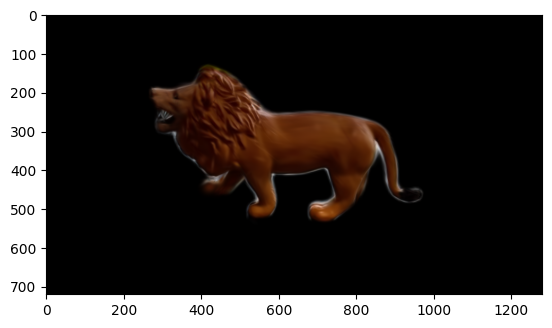

In [21]:
import tqdm
from trimesh import transform_points

obj_gaussians: GaussianModel = lion_reference_database['obj_gaussians']
camK = camKs[0]
H, W = images[0].shape[:2]
init_RT = lion_track_outputs[0]['track_pose'].copy()
# init_RT = np.eye(4)
# init_RT[2, 3] = 0.5


render = render_Gaussian_object_model(obj_gaussians, camK, init_RT, H, W, device)
# Plot render image
plt.imshow(render)

# Pixel to camera ray (assuming the camera is at the origin and rotated to identity)
def pixel_to_camera_ray(pixel, camK):
    p_pixel = np.array([pixel[0], pixel[1], 1])
    p_camera = np.linalg.inv(camK) @ p_pixel
    d_ray = p_camera / np.linalg.norm(p_camera)
    return d_ray

d_ray = pixel_to_camera_ray([600, 300], camK)

# -- Get the Gaussian splat points
gaussian_points_original = obj_gaussians.get_xyz.squeeze().detach().cpu().numpy()
gaussian_rotations = obj_gaussians.get_rotation.squeeze().detach().cpu().numpy()
gaussian_scalings = obj_gaussians.get_scaling.squeeze().detach().cpu().numpy()
gaussian_opacities = obj_gaussians.get_opacity.squeeze().detach().cpu().numpy()
# -- Move the Gaussian points according to init_RT
gaussian_points = gaussian_points_original @ init_RT[:3, :3] + init_RT[:3, 3]
# R_quat = matrix_to_quaternion(torch.tensor(init_RT[:3, :3]))
# gaussian_rotations = quaternion_multiply(R_quat, torch.tensor(gaussian_rotations))
# gaussian_points_2 = apply_transformation(gaussian_points_original, init_RT[:3, :3], init_RT[:3, 3], center) # Note: This is wrong, turns out GS Pose outputs rot with respect to camera?
# Ray x Splat intersection
# Intersect the ray with the Gaussian splat (assuming ray from origin)
def intersect_ray_with_splat(d_ray, gaussian_points, gaussian_rotations, gaussian_scalings, gaussian_opacities):
    intersections = []
    for xyz, rotation, scaling, opacity in zip(gaussian_points, gaussian_rotations, gaussian_scalings, gaussian_opacities):
        # if opacity < 0.8 or xyz[2] < 0.2:
        #     continue
        R = quaternion_to_matrix(torch.tensor(rotation)).numpy()
        
        # Transform ray to splat's local space
        local_origin = - R.T @ xyz
        local_direction = R.T @ d_ray
        
        # Scale
        local_origin /= scaling
        local_direction /= scaling
        
        # Ray-sphere intersection
        a = np.dot(local_direction, local_direction)
        b = 2 * np.dot(local_direction, local_origin)
        c = np.dot(local_origin, local_origin) - 1
        
        discriminant = b**2 - 4*a*c
        if discriminant < 0:
            # print('No intersection')
            continue
        
        t = (-b - np.sqrt(discriminant)) / (2 * a)
        
        if t < 0:
            # print('No intersection (behind the camera)')
            continue
        
        local_intersection = local_origin + t * local_direction
        
        world_intersection = R @ (scaling * local_intersection) + xyz
        
        # print(world_intersection)
        intersections.append((world_intersection, t, opacity, xyz, scaling))
        
    sorted_intersections = sorted(intersections, key=lambda x: x[1])
    
    if len(sorted_intersections) == 0:
        return None
    return sorted_intersections[0]


intersections = []
# for p in tqdm.tqdm(xyzt[0]):
for p in [[600, 300, 0]]:
    d_ray = pixel_to_camera_ray(p[:2], camK)
    intersection = intersect_ray_with_splat(d_ray, gaussian_points, gaussian_rotations, gaussian_scalings, gaussian_opacities)
    if intersection is not None:
        intersections.append(intersection)


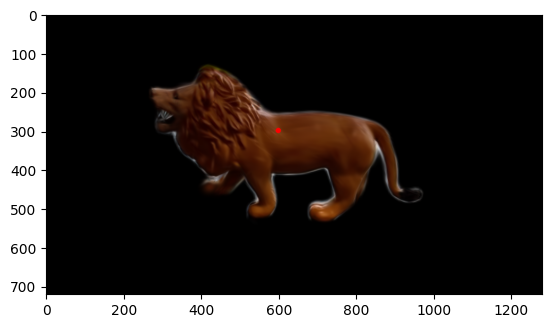

In [24]:
# Render the intersection points
rendered_points = []
intersected_points = [intersection[3] for intersection in intersections]
intersection_points = [intersection[0] for intersection in intersections]
for p in intersection_points:
    p_pixel = np.array(camK @ p)
    p_pixel = p_pixel / p_pixel[2]
    p_pixel = p_pixel[:2].astype(int)
    rendered_points.append(p_pixel)

rendered_image = render.copy()
for p in rendered_points:
    cv2.circle(rendered_image, tuple(p), 7, (255, 0, 0), -1)
    
plt.imshow(rendered_image)


In [25]:
plot_gaussian_splat(reference_database=lion_reference_database, pose=torch.tensor(init_RT, dtype=torch.float32), other_points=torch.tensor(intersection_points))
# plot_point_cloud(torch.tensor(gaussian_points_2))
# plot_point_cloud(torch.tensor(intersected_points))
# # Plot intersection points
# intersections = np.array(intersections)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(intersections[:, 0], intersections[:, 2], -intersections[:, 1])
# # Add axis labels
# ax.set_xlabel('X')
# ax.set_ylabel('Z')
# ax.set_zlabel('Y')
# plt.show()